In [1]:
%load_ext autoreload
%autoreload 2

This notebook introduces the problem addressed in this paper:

 - localizating an object in a large image
 - foveation
 - action (saccade)
 

In [2]:
%run 0_parameters.ipynb

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
2019-03-12


In [3]:
figname = '../paper/fig_intro'

# process generating display images

## Loading the MNIST dataset

In [4]:
from retina import get_data_loader

In [5]:
loader = get_data_loader(batch_size=100, train=False)

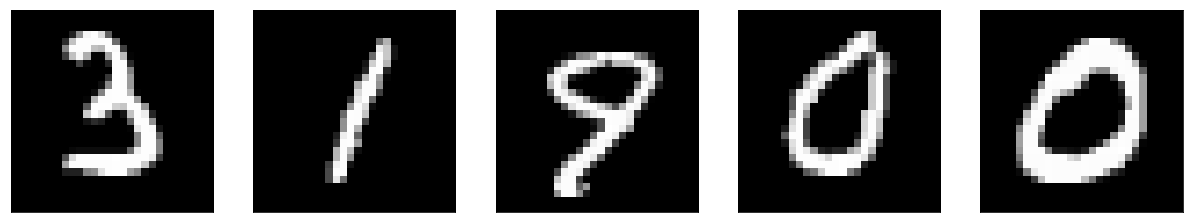

In [6]:
N_plot = 5
fig, axs = plt.subplots(1, N_plot, figsize = (21, 5))
for ax in axs:
    data, label = next(iter(loader))
    ax.imshow(data[0, 0, :, :], cmap=plt.gray())
    ax.set_xticks([])
    ax.set_yticks([])


## placing the digits in some random noise

In [7]:
N_pic = 128

minibatch_size = 100  # quantity of examples that'll be processed
lr = 1e-4 #1e-3  #0.05

OFFSET_STD = 40 #
OFFSET_MAX = 30 #
NOISE = 1. #0 #
CONTRAST = 0.4 #1 #
sf_0 = 0.2
B_sf = 0.3

In [8]:
from retina import minmax, place_object

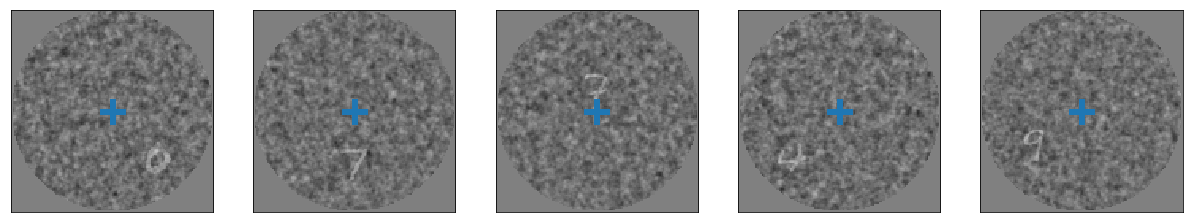

In [9]:
N_plot = 5
fig, axs = plt.subplots(1, N_plot, figsize = (21, 8))
for ax in axs:
    data, label = next(iter(loader))
    offset_std = OFFSET_STD
    offset_max = OFFSET_MAX
    i_offset = minmax(np.random.randn() * offset_std, offset_max)
    j_offset = minmax(np.random.randn() * offset_std, offset_max)
    data_fullfield = place_object(data[0, 0, :, :].numpy(), i_offset, j_offset,  N_pic=N_pic,
                                    CONTRAST=CONTRAST, NOISE=NOISE,
                                    sf_0=sf_0, B_sf=B_sf)
    ax.imshow(data_fullfield, cmap=plt.gray(), vmin=0, vmax=1)
    ax.plot([N_pic//2], [N_pic//2], '+', ms=26, markeredgewidth=6)
    ax.set_xticks([])
    ax.set_yticks([])

In [10]:
data_fullfield.min(), data_fullfield.max()

(0.21499396499771917, 0.709416032095165)

In [11]:
data, label = next(iter(loader))
offset_std = OFFSET_STD
offset_max = OFFSET_MAX
i_offset = minmax(np.random.randn() * offset_std, offset_max)
j_offset = minmax(np.random.randn() * offset_std, offset_max)
data_fullfield = place_object(data[0, 0, :, :].numpy(), i_offset, j_offset,  N_pic=N_pic,
                                CONTRAST=CONTRAST, NOISE=NOISE,
                                sf_0=sf_0, B_sf=B_sf)
print('i_offset', i_offset)
print('j_offset', j_offset)


i_offset 22
j_offset -30


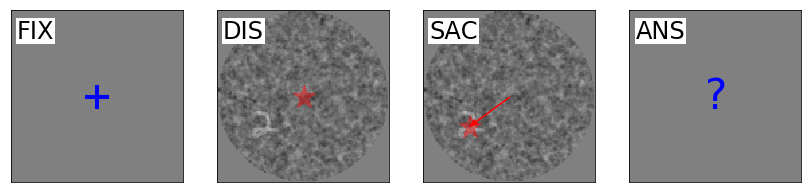

In [12]:
texts = ['FIX', 'DIS', 'SAC', 'ANS']
def panel_A(fig_A=None, axs_A=None):

    N_plot = 4

    if fig_A is None:
        fig_A, axs_A = plt.subplots(1, N_plot, figsize = (figwidth, figwidth/4))
    for ax, text in zip(axs_A, texts):
        ax.imshow(.5 + np.zeros_like(data_fullfield), cmap=plt.gray(), vmin=0, vmax=1)
        if text=='FIX': 
            ax.plot([N_pic//2], [N_pic//2], '+', color='b', ms=24, markeredgewidth=4)
        elif text in ['DIS', 'SAC']: 
            ax.imshow(data_fullfield, cmap=plt.gray(), vmin=0, vmax=1)
            opts = dict(ms=24, markeredgewidth=1, alpha=.4)
            if text == 'DIS':
                ax.plot([N_pic//2], [N_pic//2], '*r', **opts)
            else:
                ax.plot([N_pic//2+j_offset], [N_pic//2+i_offset], '*r', **opts)
                ax.arrow(N_pic//2, N_pic//2, j_offset, i_offset, width=.3, color='r', head_width=4., length_includes_head=True, edgecolor='k')
        elif text=='ANS':         
            ax.text(N_pic//2, N_pic//2, '?', color='b', fontsize=42,
              ha='center', va='center')

        ax.set_xticks([])
        ax.set_yticks([])
        ax.text(4, 15, text, fontsize=24,
              bbox={'facecolor':'white','alpha':1,'edgecolor':'none','pad':1},
              ha='left', va='center') 

    # TODO: show arrow of time
    #fig.arrow(N_pic//2, N_pic//2, j_offset - 4 * N_pic, i_offset, width=.3, color='r', head_width=4., length_includes_head=True, edgecolor='k')
    return fig_A, axs_A
fig_A, axs_A = panel_A()
#fig_A.savefig(figname + '.pdf')

# a sample saccade

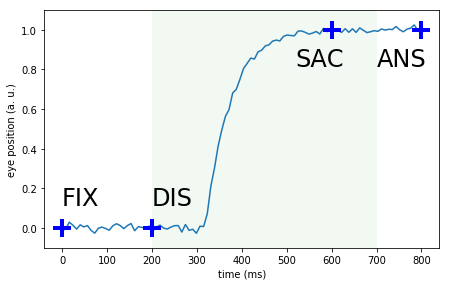

In [13]:
def panel_B(fig=None, axs=None, N_time=100, offset=.15, fontsize=24, ms=18, markeredgewidth=4):
    if fig is None:
        fig, axs = plt.subplots(1, 1, figsize=(figwidth/2, figwidth/phi/2))
    
    time = np.linspace(0, 800, N_time)
    latency = 320
    EM = 1. - np.exp(- (time-latency) / 54. ) 

    EM[time<latency] = 0
    EM += .01 * np.random.randn(N_time)

    start, sac, end = 200, 600, 700
    axs.plot(time, EM)
    axs.plot([start], [0], '+', color='b', ms=ms, markeredgewidth=markeredgewidth)
    axs.plot([sac], [1], '+', color='b', ms=ms, markeredgewidth=markeredgewidth)
    axs.plot([0], [0], '+', color='b', ms=ms, markeredgewidth=markeredgewidth)
    axs.plot([800], [1], '+', color='b', ms=ms, markeredgewidth=markeredgewidth)
    opts = dict(fontsize=fontsize,
          bbox={'facecolor':'white','alpha':0,'edgecolor':'none','pad':1},
          ha='left', va='center')
    axs.text(0, offset, 'FIX', **opts)
    axs.text(start, offset, 'DIS', **opts)
    axs.text(sac-80, 1-offset, 'SAC', **opts)
    axs.text(700, 1-offset, 'ANS', **opts)
    axs.fill_between([start, end], y1=1.15, y2=-.15, facecolor='g', alpha=.05)
    axs.set_ylim([-.1, 1.1])
    axs.set_xlabel('time (ms)')
    axs.set_ylabel('eye position (a. u.)')
    # fig_B.savefig(figname + '.pdf')
    return fig, axs

fig_B, axs_B = panel_B()

# foveation

In [14]:
N_theta = 6
N_azimuth = 16
N_eccentricity = 10
N_phase = 2
N_X = 128
N_Y = 128
rho = 1.41
verbose = 1


In [15]:
from retina import vectorization

retina_transform = vectorization(N_theta, N_azimuth, N_eccentricity, N_phase, N_X, N_Y, rho)

In [16]:
from retina import  retina, retina_inverse
retina_inverse_transform = retina_inverse(retina_transform)

In [17]:
data_retina, tensor_retina   = retina(data_fullfield, retina_transform)


#### Full encoding

In [18]:
retina_transform = vectorization(N_theta, N_azimuth, N_eccentricity, N_phase, N_X, N_Y, rho)
print(retina_transform.shape)

(6, 16, 10, 2, 16384)


In [19]:
retina_vector = retina_transform.reshape((N_theta*N_azimuth*N_eccentricity*N_phase, N_X*N_Y))
print(retina_vector.shape)

(1920, 16384)


In [20]:
retina_inverse = np.linalg.pinv(retina_vector)
print(retina_inverse.shape)

(16384, 1920)


In [21]:
data_fullfield_0 = place_object(data[0, 0, :, :].numpy(), 0, 0,  N_pic=N_pic,
                                CONTRAST=CONTRAST, NOISE=NOISE,
                                sf_0=sf_0, B_sf=B_sf)

data_retina_0, tensor_retina   = retina(data_fullfield_0, retina_transform)
im_0 = retina_inverse_transform @ data_retina_0
im_0 = im_0.reshape((N_pic, N_pic))

data_retina, tensor_retina   = retina(data_fullfield, retina_transform)
im = retina_inverse_transform @ data_retina
im = im.reshape((N_pic, N_pic))


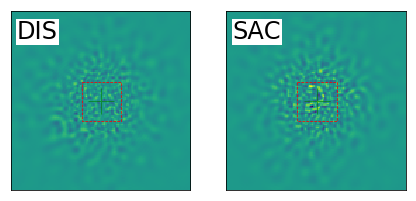

In [22]:
def panel_C(fig_C=None, axs_C=None, w=28):
    
    rmin = min((im.min(), im_0.min()))
    rmax = max((im.max(), im_0.max()))
    if fig_C is None:
        fig_C, axs_C = plt.subplots(1, 2, figsize=(figwidth/2, figwidth/phi/2))
    for ax, text in zip(axs_C, texts[1:3]):
        opts = dict(ms=26, markeredgewidth=1, alpha=.6)
        if text == 'DIS':
            ax.imshow(im, cmap=plt.viridis(), vmin=rmin, vmax=rmax)
            ax.plot([N_pic//2], [N_pic//2], '+g', **opts)
        else:
            ax.imshow(im_0, cmap=plt.viridis(), vmin=rmin, vmax=rmax)
            ax.plot([N_pic//2], [N_pic//2], '+g', **opts)

        ax.set_xticks([])
        ax.set_yticks([])
        # ax.plot([N_pic//2], [N_pic//2], '+', color='r', ms=26, markeredgewidth=1)
        ax.plot([N_pic//2-w/2, N_pic//2+w/2, N_pic//2+w/2, N_pic//2-w/2, N_pic//2-w/2], 
                [N_pic//2-w/2, N_pic//2-w/2, N_pic//2+w/2, N_pic//2+w/2, N_pic//2-w/2], '--', color='r', lw=.75, markeredgewidth=1)
        
        ax.text(4, 15, text, fontsize=24,
              bbox={'facecolor':'white','alpha':1,'edgecolor':'none','pad':1},
              ha='left', va='center') 

    return fig_C, axs_C
fig_C, axs_C = panel_C()
# fig_B.savefig(figname + '.pdf')

# summary

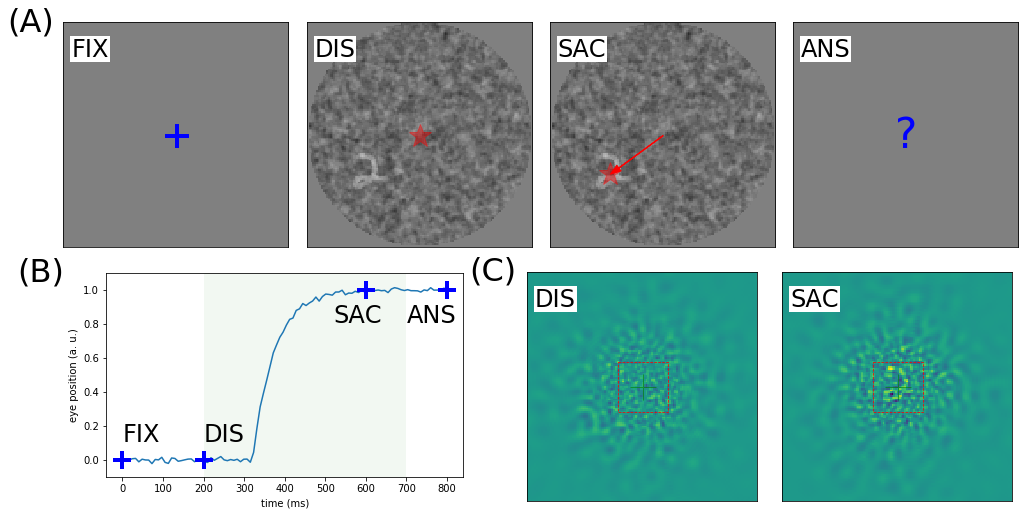

In [23]:
# fig = plt.figure(figsize = (21, 13))
fig, axs = plt.subplots(2, 4, figsize = (figwidth, figwidth/2), constrained_layout=True)
    
fig, axs_A = panel_A(fig_A=fig, axs_A=axs[0])
fig, axs_B = panel_B(fig=fig, axs=axs[1][0])
fig, axs_C = panel_C(fig_C=fig, axs_C=axs[1][1:3])
axs[1][3].remove()
# pos : [left, bottom, width, height] =    The new position of the in `.Figure` coordinates.
axs_B.set_position([0.1, 0.0725, .35, 0.4])
axs_C[0].set_position([0.4, .025, .45, .45])
axs_C[1].set_position([0.65, .025, .45, .45])
offset = -.25
for ax, text, x, y in [[axs_A[0], 'A', offset, 1], [axs_B, 'B', offset, 1], [axs_C[0], 'C', offset, 1]]:
    ax.text(x, y, '(' + text + ')', fontsize=32,
              bbox={'facecolor':'white','alpha':1,'edgecolor':'none','pad':1},
              ha='left', va='center', transform=ax.transAxes) 

#plt.tight_layout()
fig.savefig(figname + '.pdf', bbox_inches='tight', pad_inches=0.1)

# post-processing

In [24]:
!convert  -density {dpi_export} {figname}.pdf {figname}.jpg
!convert  -density {dpi_export} {figname}.pdf {figname}.png
#!convert  -density {dpi_export} -resize 5400  -units pixelsperinch -flatten  -compress lzw  -depth 8 {fname}.pdf {fname}.tiff

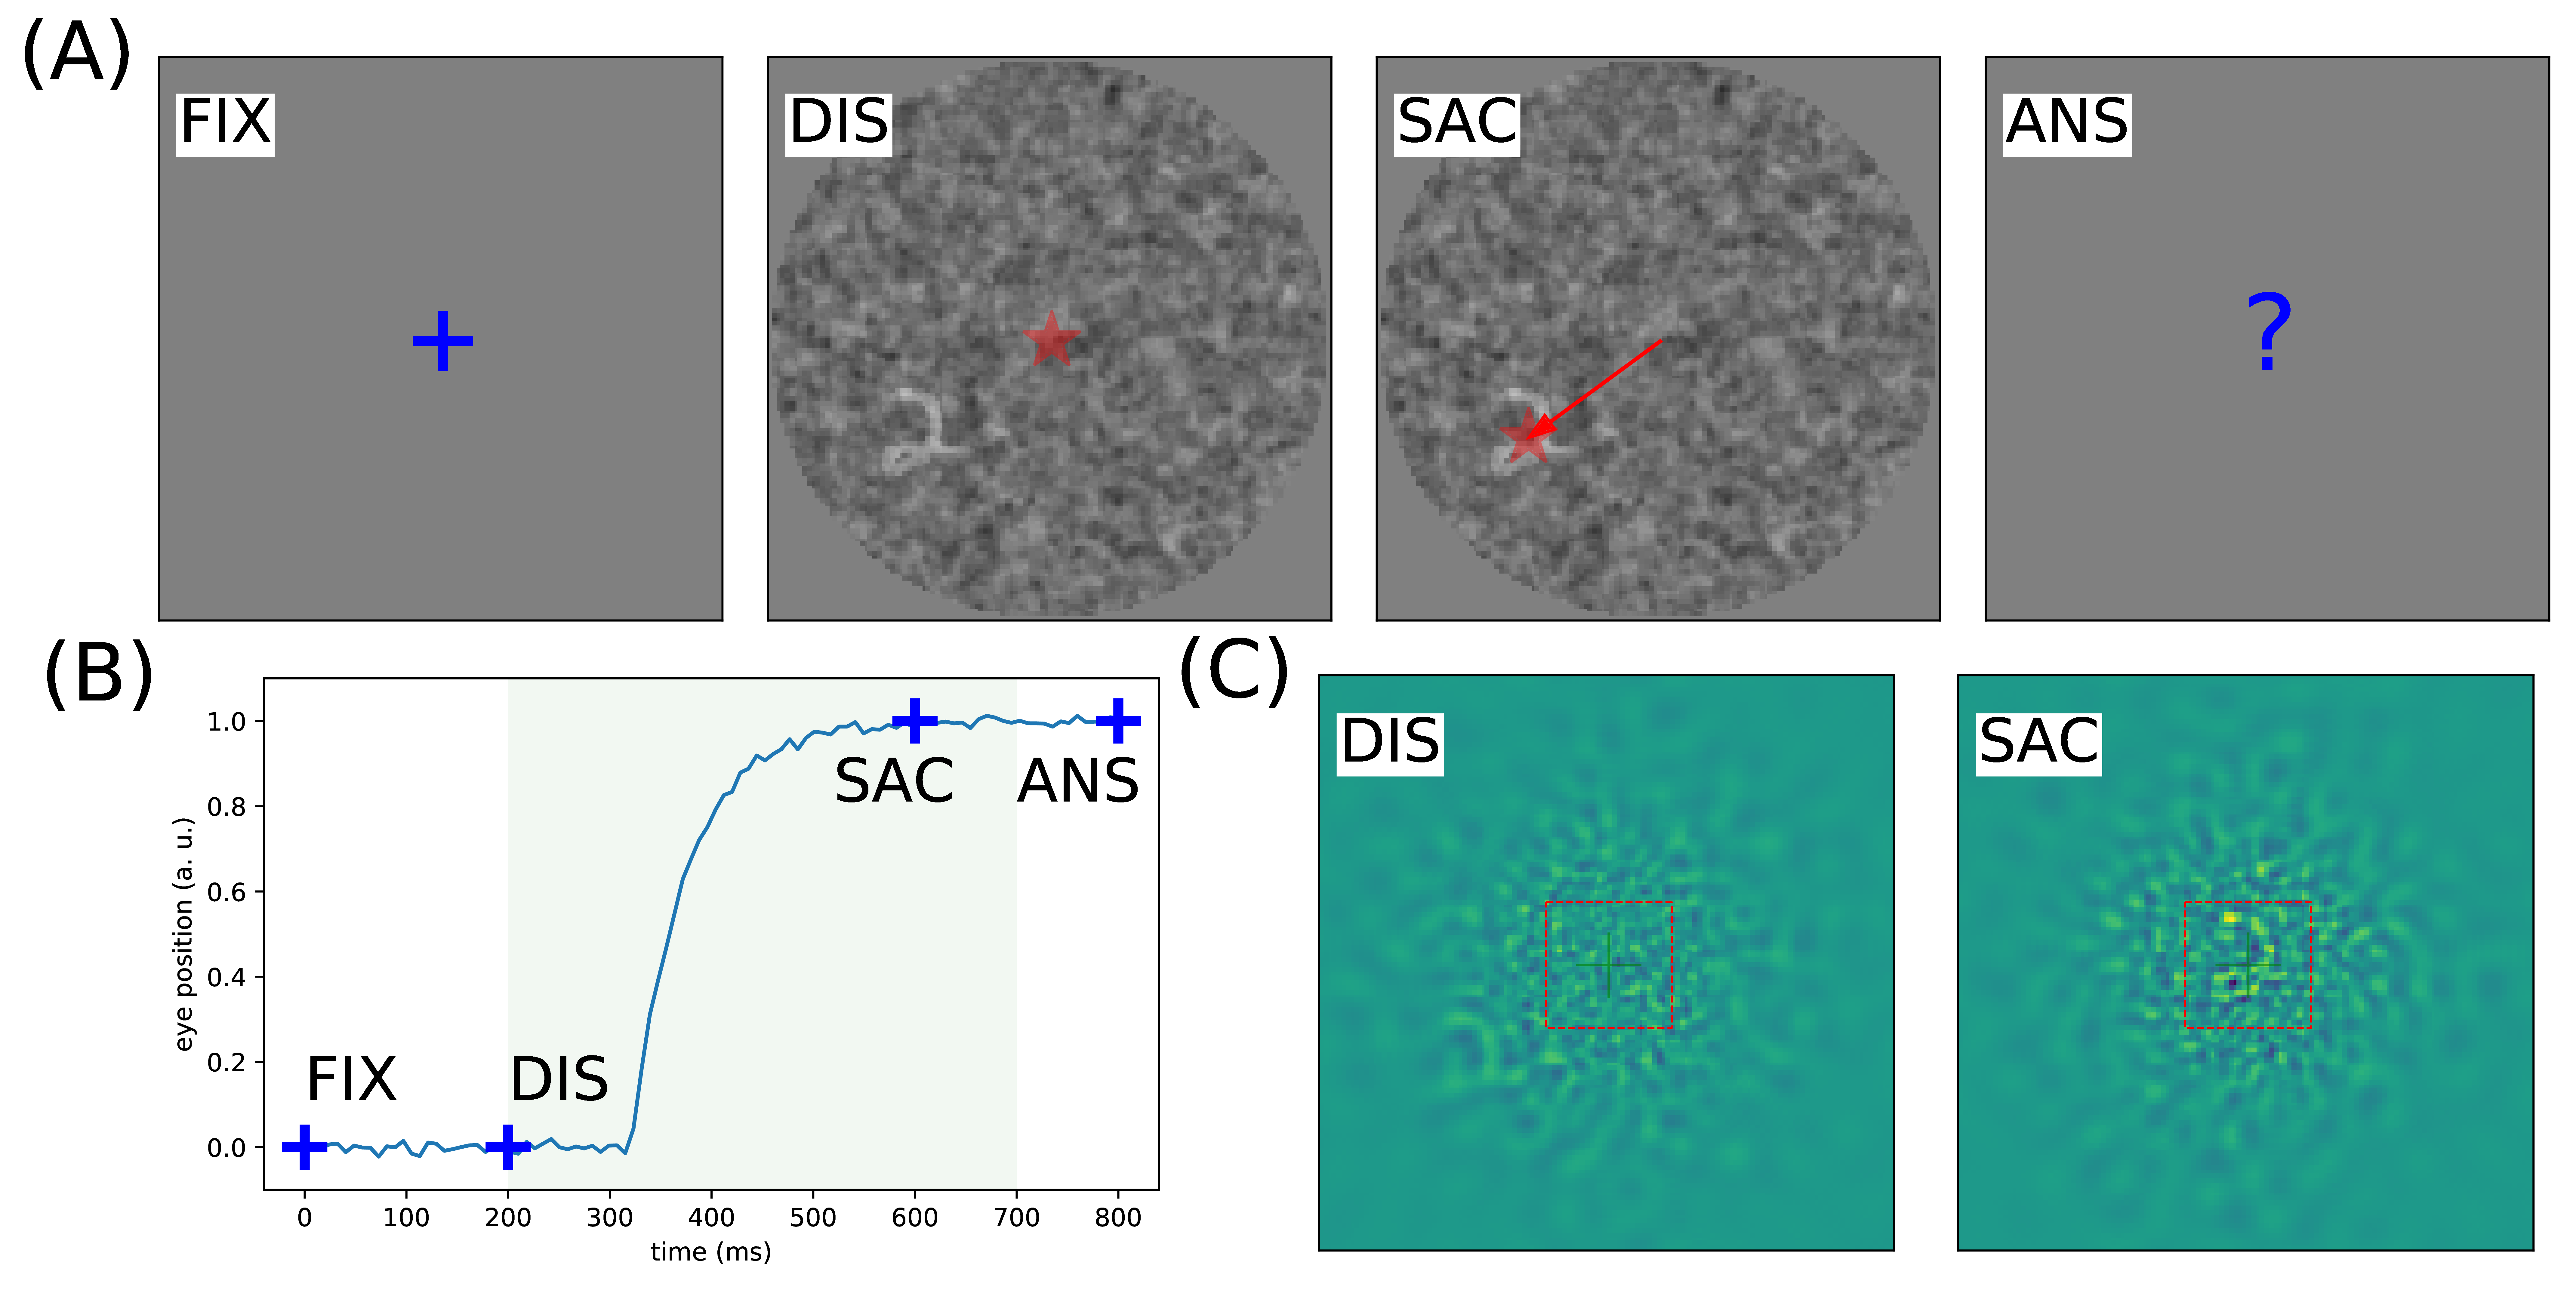

In [25]:
from IPython.display import Image
Image('{figname}.png'.format(figname=figname))

In [26]:
!ls  -l {figname}*

-rw-r--r--  1 laurentperrinet  staff  2019846 Mar 12 11:05 ../paper/fig_intro.jpg
-rw-r--r--  1 laurentperrinet  staff   104018 Mar 12 11:05 ../paper/fig_intro.pdf
-rw-r--r--  1 laurentperrinet  staff   448103 Mar 12 11:05 ../paper/fig_intro.png


## Version used

In [27]:
%load_ext version_information
%version_information numpy, shl_scripts

The version_information extension is already loaded. To reload it, use:
  %reload_ext version_information


Software versions
Python 3.7.2 64bit [Clang 10.0.0 (clang-1000.11.45.5)]
IPython 7.3.0
OS Darwin 18.2.0 x86_64 i386 64bit
numpy 1.16.2
shl_scripts 20171221
Tue Mar 12 11:05:56 2019 CET